<a href="https://colab.research.google.com/github/Aadhavan-27/vancomycin-dose-prediction/blob/main/Vancomycin_trough.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U xgboost


Rows,Cols: (10000, 22)
['patient_id', 'age_yrs', 'sex', 'weight_kg', 'serum_creatinine_mg_dL', 'creatinine_clearance_mL_min', 'ckd_flag', 'nephrotoxic_med_flag', 'sepsis_flag', 'alt_U_L', 'ast_U_L', 'albumin_g_dL', 'dose_mg', 'dosing_interval_hr', 'infusion_time_hr', 'time_since_last_dose_hr', 'Vd_L', 'kel_1_per_hr', 'simulated_trough_mg_L', 'category', 'admission_time', 'sample_time']
Train shape: (8000, 12) Test shape: (2000, 12)

Random Forest performance:
MAE: 3.809 mg/L  |  RMSE: 5.810 mg/L  |  R2: 0.988
xgboost version does not accept early_stopping_rounds in fit(); training without early stopping.

XGBoost performance:
MAE: 3.966 mg/L  |  RMSE: 5.541 mg/L  |  R2: 0.989


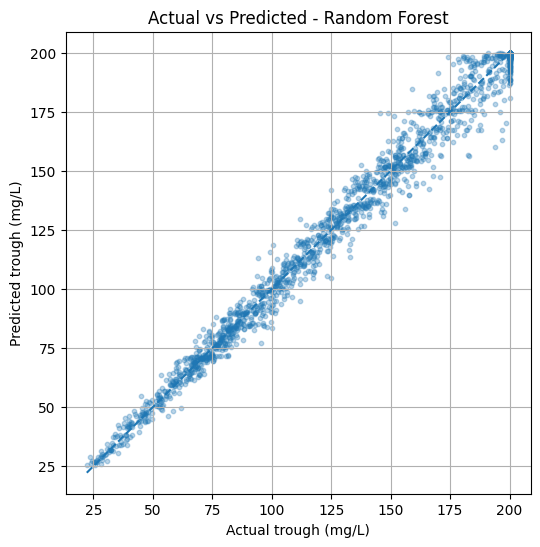


Feature importances (Random Forest):
                    feature  importance
         dosing_interval_hr    0.438651
                    dose_mg    0.393604
                  weight_kg    0.136218
       nephrotoxic_med_flag    0.018807
                sepsis_flag    0.008660
               albumin_g_dL    0.001387
creatinine_clearance_mL_min    0.000843
           infusion_time_hr    0.000627
     serum_creatinine_mg_dL    0.000569
                    age_yrs    0.000506
                   sex_male    0.000091
                   ckd_flag    0.000037

Sample patient features (base):
{'age_yrs': 87.0, 'weight_kg': 76.0, 'sex_male': 1.0, 'serum_creatinine_mg_dL': 1.91, 'creatinine_clearance_mL_min': 29.29, 'albumin_g_dL': 3.5, 'ckd_flag': 1.0, 'nephrotoxic_med_flag': 0.0, 'sepsis_flag': 0.0, 'dose_mg': 1250.0, 'dosing_interval_hr': 12.0, 'infusion_time_hr': 0.53}

Recommended dose (Random Forest): {'dose': 500.0, 'pred_trough': 71.68177434136653, 'dist': 56.681774341366534}

Grid predic

In [ ]:

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

try:
    import xgboost as xgb
    from xgboost import XGBRegressor
except Exception:
    print("xgboost not found. To install run: pip install xgboost")
    XGBRegressor = None


df = pd.read_csv("enhanced_synthetic_vancomycin_10000.csv")
print("Rows,Cols:", df.shape)
print(df.columns.tolist())

features = [
    "age_yrs", "weight_kg", "sex", "serum_creatinine_mg_dL",
    "creatinine_clearance_mL_min", "albumin_g_dL",
    "ckd_flag", "nephrotoxic_med_flag", "sepsis_flag",
    "dose_mg", "dosing_interval_hr", "infusion_time_hr"
]


df_model = df[features + ["simulated_trough_mg_L", "category"]].copy()
df_model.dropna(inplace=True)


df_model["sex_male"] = (df_model["sex"] == "Male").astype(int)
df_model.drop(columns=["sex"], inplace=True)


X_cols = [
    "age_yrs", "weight_kg", "sex_male", "serum_creatinine_mg_dL",
    "creatinine_clearance_mL_min", "albumin_g_dL",
    "ckd_flag", "nephrotoxic_med_flag", "sepsis_flag",
    "dose_mg", "dosing_interval_hr", "infusion_time_hr"
]

X = df_model[X_cols]
y = df_model["simulated_trough_mg_L"]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


rf = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)


def regression_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2


mae_rf, rmse_rf, r2_rf = regression_metrics(y_test, y_pred_rf)
print("\nRandom Forest performance:")
print(f"MAE: {mae_rf:.3f} mg/L  |  RMSE: {rmse_rf:.3f} mg/L  |  R2: {r2_rf:.3f}")


use_xgb = XGBRegressor is not None
if use_xgb:
    xgb_model = XGBRegressor(n_estimators=300, max_depth=6, learning_rate=0.05, random_state=42, verbosity=0, n_jobs=4)
    try:

        xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=30, verbose=False)
    except TypeError:

        print("xgboost version does not accept early_stopping_rounds in fit(); training without early stopping.")
        xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_test)
    mae_xgb, rmse_xgb, r2_xgb = regression_metrics(y_test, y_pred_xgb)
    print("\nXGBoost performance:")
    print(f"MAE: {mae_xgb:.3f} mg/L  |  RMSE: {rmse_xgb:.3f} mg/L  |  R2: {r2_xgb:.3f}")
else:
    print("\nXGBoost not available in this environment (install xgboost to use it).")



plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_rf, alpha=0.3, s=10)
_min = min(y_test.min(), y_pred_rf.min())
_max = max(y_test.max(), y_pred_rf.max())
plt.plot([_min, _max], [_min, _max], linestyle='--')
plt.xlabel("Actual trough (mg/L)")
plt.ylabel("Predicted trough (mg/L)")
plt.title("Actual vs Predicted - Random Forest")
plt.grid(True)
plt.show()


importances = rf.feature_importances_
imp_df = pd.DataFrame({"feature": X_cols, "importance": importances}).sort_values("importance", ascending=False)
print("\nFeature importances (Random Forest):")
print(imp_df.to_string(index=False))



def recommend_dose_for_patient(patient_row, model, doses = [250,500,750,1000,1250,1500,1750,2000], target_range=(10,20)):
    """Return recommended dose (mg) and predicted trough for that dose."""
    X_base = patient_row.copy()
    results = []
    for d in doses:
        X_try = X_base.copy()
        X_try["dose_mg"] = d

        X_try_arr = X_try[X_cols].values.reshape(1, -1)
        pred = model.predict(X_try_arr)[0]
        results.append({"dose": d, "pred_trough": float(pred)})
    df_res = pd.DataFrame(results)
    inside = df_res[(df_res["pred_trough"] >= target_range[0]) & (df_res["pred_trough"] <= target_range[1])]
    if len(inside) > 0:
        chosen = inside.sort_values("dose").iloc[0]
    else:
        midpoint = sum(target_range)/2.0
        df_res["dist"] = (df_res["pred_trough"] - midpoint).abs()
        chosen = df_res.sort_values("dist").iloc[0]
    return chosen, df_res

sample_index = X_test.index[0]
sample_patient = X_test.loc[sample_index].to_dict()
print("\nSample patient features (base):")
print(sample_patient)

chosen, df_grid = recommend_dose_for_patient(pd.Series(sample_patient), rf, doses=[250,500,750,1000,1250,1500,1750,2000], target_range=(10,20))
print("\nRecommended dose (Random Forest):", chosen.to_dict())
print("\nGrid predictions (dose -> predicted trough):")
print(df_grid.to_string(index=False))

def recommend_for_many(df_patients, model, doses=[250,500,750,1000,1250,1500], target_range=(10,20)):
    recs = []
    for i, row in df_patients.iterrows():
        chosen, _ = recommend_dose_for_patient(row, model, doses=doses, target_range=target_range)
        recs.append({
            "index": i, "chosen_dose": int(chosen["dose"]), "pred_trough": float(chosen["pred_trough"])
        })
    return pd.DataFrame(recs)

sample_patients = X_test.sample(5, random_state=42)
recs_df = recommend_for_many(sample_patients, rf)
print("\nRecommendations for 5 random test patients:")
print(recs_df.to_string(index=False))


